In [1]:
import sys

module_dir = '../'

if module_dir not in sys.path:
    sys.path.append(module_dir)

import numpy as np
import matplotlib.pyplot as plt
import sklearn as skl
from models import *
import test_systems_1d as systems_1d
import itertools
from matplotlib.colors import TwoSlopeNorm
from matplotlib.colors import NoNorm
from tqdm import tqdm
import gpjax as gpx

/Users/tomcowperthwaite/opt/anaconda3/envs/mres2/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Training

In [92]:
# Display?
display_subset = False
how_many = 5
####################

# Parameters
n_features = 1000
n_targets = n_features

n_samples_V_train = 5
n_samples_H_0_train = 5
v_range_train = (1, 10)
H_0_range_train = (1, 10)

x_range = (-25, 25)
####################

x = np.linspace(x_range[0], x_range[1], n_features)

rng = np.random.default_rng(seed=99)
V_arr_train = np.random.uniform(v_range_train[0], v_range_train[1], n_samples_V_train)
H_0_arr_train = np.random.uniform(H_0_range_train[0], H_0_range_train[1], n_samples_H_0_train)

train_params = np.array(list(itertools.product(V_arr_train, H_0_arr_train)))
n_samples_train = train_params.shape[0]

x_train = np.zeros((n_samples_train, n_features))
y_train = np.zeros((n_samples_train, n_targets))

for i, params in enumerate(train_params):
    x_train[i, :] = systems_1d.diffusion(x = x, t = 0, D = 1, V = train_params[i, 0], H_0 = train_params[i, 1])
    y_train[i, :] = systems_1d.diffusion(x = x, t = 5, D = 1, V = train_params[i, 0], H_0 = train_params[i, 1])

    if (i+1) % int(n_samples_train/how_many) == 0 and display_subset:
        print(f'{i+1}/{n_samples_train}: V = {params[0]}, H_0 = {params[1]}')
        plt.figure()
        plt.plot(x, x_train[i, :], label='x_train')
        plt.plot(x, y_train[i, :], label='y_train')
        plt.legend()
        plt.show()


In [93]:
low_dim_x = 2
low_dim_y = 1

reg = first_model(low_dim_x=low_dim_x, low_dim_y=low_dim_y, low_dim_regressor=GP_regressor())
reg.fit(x_train, y_train, save=True)

(25, 2)
(25, 1)
         Current function value: 15.848064
         Iterations: 22
         Function evaluations: 116
         Gradient evaluations: 104
(25,)
(25, 1)


/Users/tomcowperthwaite/opt/anaconda3/envs/mres2/lib/python3.10/site-packages/scipy/optimize/_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


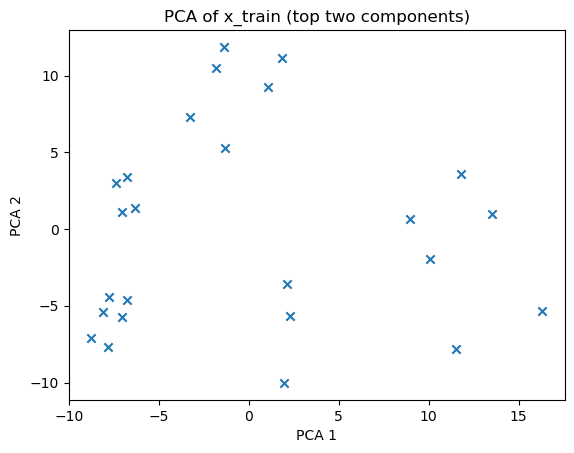

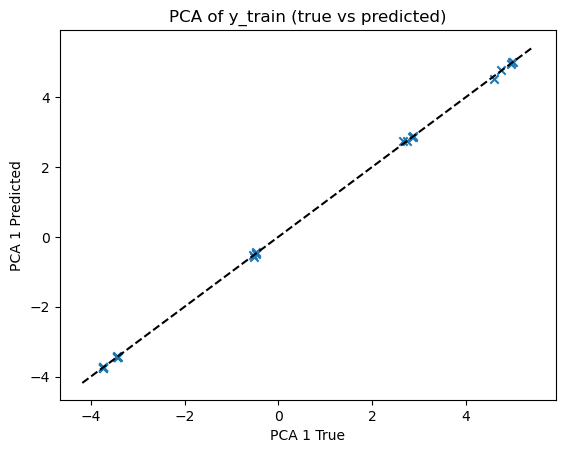

MSE: 0.0010295843477931943
Correlation: 0.9999552289140758


In [94]:
# assess how well the low-dimensional regression is doing

if low_dim_x > 1:
    plt.figure()
    plt.scatter(reg.X_train_low_dim[:, 0], reg.X_train_low_dim[:, 1], marker='x', alpha=1)
    plt.xlabel('PCA 1')
    plt.ylabel('PCA 2')
    plt.title('PCA of x_train (top two components)')
    plt.show()

plt.figure()
ax = plt.gca()
plt.scatter(reg.Y_train_low_dim[:, 0], reg.Y_train_low_dim_pred[:, 0], marker='x', alpha=1)
plt.plot(np.linspace(min(ax.get_xlim()[0], ax.get_ylim()[0]), max(ax.get_xlim()[1], ax.get_ylim()[1]), num=2), np.linspace(min(ax.get_xlim()[0], ax.get_ylim()[0]), max(ax.get_xlim()[1], ax.get_ylim()[1]), num=2), linestyle='--', color='black')
plt.xlabel('PCA 1 True')
plt.ylabel('PCA 1 Predicted')
plt.title('PCA of y_train (true vs predicted)')
plt.show()

mse = skl.metrics.mean_squared_error(reg.Y_train_low_dim, reg.Y_train_low_dim_pred)
print(f'MSE: {mse}')
r = np.corrcoef(reg.Y_train_low_dim[:, 0], reg.Y_train_low_dim_pred[:, 0])
print(f'Correlation: {r[0, 1]}')

# Testing

In [95]:
n_samples_V_test = 40
n_samples_H_0_test = 40

rng = np.random.default_rng(seed=98)
V_arr_test = np.linspace(1, 20, n_samples_V_test)
H_0_arr_test = np.linspace(1, 20, n_samples_H_0_test)

test_params = np.array(list(itertools.product(V_arr_test, H_0_arr_test)))
n_samples_test = test_params.shape[0]
test_params_arr = test_params.reshape((n_samples_V_test, n_samples_H_0_test, 2))

x_test = np.zeros((n_samples_test, n_features))
y_test = np.zeros((n_samples_test, n_targets))

for i, params in enumerate(test_params):
    x_test[i, :] = systems_1d.diffusion(x = x, t = 0, D = 1, V = test_params[i, 0], H_0 = test_params[i, 1])
    y_test[i, :] = systems_1d.diffusion(x = x, t = 5, D = 1, V = test_params[i, 0], H_0 = test_params[i, 1])

/var/folders/pq/m1s3wh755x9fhcy2gq520_3r0000gn/T/ipykernel_26603/2778574222.py:12: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  worst_index_rmse = int(np.where(rmse == np.max(rmse))[0])


index 1599 was the worst result with an RMSE of 0.58117010410278 for V=20.0 and H_0=20.0


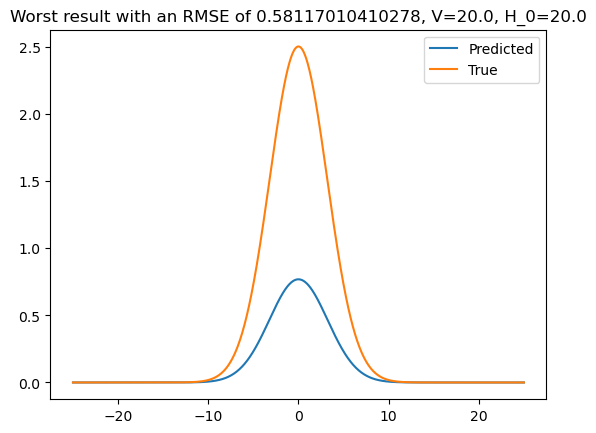

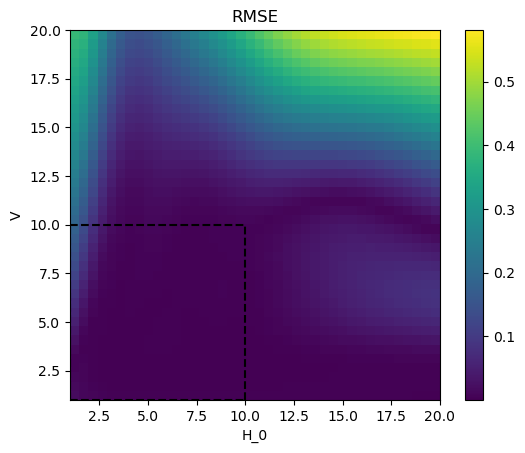

index 1560 was the worst result with an R^2 of -0.4544130575474188 for V=20.0 and H_0=1.0


/var/folders/pq/m1s3wh755x9fhcy2gq520_3r0000gn/T/ipykernel_26603/2778574222.py:34: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  worst_index_r2 = int(np.where(r2 == np.min(r2))[0])


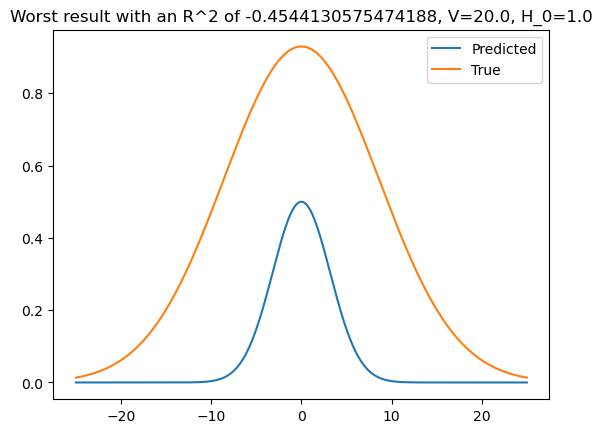

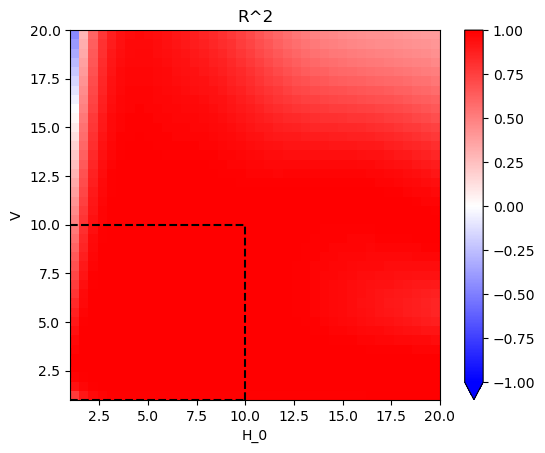

In [96]:
def plot_box(x_coords, y_coords):
    plt.vlines(x_coords[0], y_coords[0], y_coords[1], color='black', linestyle='--')
    plt.vlines(x_coords[1], y_coords[0], y_coords[1], color='black', linestyle='--')
    plt.hlines(y_coords[0], x_coords[0], x_coords[1], color='black', linestyle='--')
    plt.hlines(y_coords[1], x_coords[0], x_coords[1], color='black', linestyle='--')

y_test_pred = reg.predict(x_test)

rmse, r2 = reg.test(x_test, y_test)

# RMSE
worst_index_rmse = int(np.where(rmse == np.max(rmse))[0])
print(f'index {worst_index_rmse} was the worst result with an RMSE of {rmse[worst_index_rmse]} for V={test_params[worst_index_rmse, 0]} and H_0={test_params[worst_index_rmse, 1]}')

plt.figure()
plt.plot(x, y_test_pred[worst_index_rmse, :], label='Predicted')
plt.plot(x, y_test[worst_index_rmse, :], label='True')
plt.legend()
plt.title(f'Worst result with an RMSE of {rmse[worst_index_rmse]}, V={test_params[worst_index_rmse, 0]}, H_0={test_params[worst_index_rmse, 1]}')
plt.show()

rmse_arr = rmse.reshape((n_samples_V_test, n_samples_H_0_test))

plt.figure()
plt.imshow(rmse_arr[:, :], origin='lower', extent=[H_0_arr_test[0], H_0_arr_test[-1], V_arr_test[0], V_arr_test[-1]], cmap='viridis')
plt.colorbar()
plot_box(H_0_range_train, v_range_train)
plt.xlabel('H_0')
plt.ylabel('V')
plt.title('RMSE')
plt.show()

# R2
worst_index_r2 = int(np.where(r2 == np.min(r2))[0])
print(f'index {worst_index_r2} was the worst result with an R^2 of {r2[worst_index_r2]} for V={test_params[worst_index_r2, 0]} and H_0={test_params[worst_index_r2, 1]}')

plt.figure()
plt.plot(x, y_test_pred[worst_index_r2, :], label='Predicted')
plt.plot(x, y_test[worst_index_r2, :], label='True')
plt.legend()
plt.title(f'Worst result with an R^2 of {r2[worst_index_r2]}, V={test_params[worst_index_r2, 0]}, H_0={test_params[worst_index_r2, 1]}')
plt.show()

r2_arr = r2.reshape((n_samples_V_test, n_samples_H_0_test))

plt.figure()
divnorm = TwoSlopeNorm(vmin=-1, vcenter=0, vmax=1)
plt.imshow(r2_arr[:, :], origin='lower', extent=[H_0_arr_test[0], H_0_arr_test[-1], V_arr_test[0], V_arr_test[-1]], cmap='bwr', norm=divnorm)
plt.colorbar(extend='min')
plot_box(H_0_range_train, v_range_train)
plt.xlabel('H_0')
plt.ylabel('V')
plt.title('R^2')
plt.show()